In [304]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.stats import skew
import os
# fastica, picard, infomax. Picard maybe better

In [87]:
filename_list = [
'EEGdata-2024-144--14-24-41',
'EEGdata-2024-144--14-47-17',
'EEGdata-2024-144--14-56-37',
'EEGdata-2024-144--15-28-30',
'EEGdata-2024-144--15-54-35',
'EEGdata-2024-148--14-42-07',
'EEGdata-2024-148--14-48-17',
'EEGdata-2024-148--14-55-39',
'EEGdata-2024-149--15-20-21',
'EEGdata-2024-149--15-35-40',
'EEGdata-2024-149--15-45-38',
'EEGdata-2024-149--15-57-42',
'EEGdata-2024-149--16-41-44',
'EEGdata-2024-150--14-48-32',
'EEGdata-2024-150--14-55-28',
'EEGdata-2024-150--15-01-30',
'EEGdata-2024-150--15-07-57',
'EEGdata-2024-150--15-14-53',
'EEGdata-2024-150--15-30-23',
'EEGdata-2024-150--15-36-40',
'EEGdata-2024-150--15-42-38',
'EEGdata-2024-156--14-35-07',
'EEGdata-2024-156--14-42-54',
'EEGdata-2024-156--14-51-06',
'EEGdata-2024-156--14-58-57',
'EEGdata-2024-156--15-06-57',
'EEGdata-2024-156--15-21-50',
'EEGdata-2024-156--15-27-22',
'EEGdata-2024-162--11-15-01',
'EEGdata-2024-162--11-20-53',
'EEGdata-2024-162--11-28-38',
'EEGdata-2024-162--11-35-23']

In [373]:
# Select file from measurement
# Change next to lines if needed
path = "C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/"
filename = filename_list[5]

In [374]:

df = pd.read_csv(path+filename + ".csv", sep=",")
end = df.shape[0] # Remove 5 samples buffer at the end
fs = 250
df = df.iloc[:end, :8] # Select 72000 samples from 8 channels
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,221817.375000,232588.687500,353448.25000,349214.65625,213016.781250,226099.437500,230300.406250,210024.687500
1,221425.593750,231857.703125,353045.03125,348647.34375,212467.921875,225857.328125,228656.390625,209441.671875
2,221146.109375,231219.953125,352668.15625,348147.93750,211901.796875,225683.703125,226783.312500,208942.156250
3,221377.140625,231565.781250,352843.40625,348413.56250,212112.609375,225825.765625,227307.156250,209236.031250
4,221793.328125,232405.843750,353318.43750,349058.81250,212800.953125,226090.046875,229456.140625,209901.484375
...,...,...,...,...,...,...,...,...
72000,220058.296875,231249.187500,271521.21875,266073.31250,209578.906250,224331.421875,223781.468750,208668.390625
72001,220039.171875,231128.218750,271420.90625,265959.12500,209401.437500,224317.375000,223076.859375,208580.953125
72002,220395.000000,231815.859375,271806.87500,266511.84375,209940.828125,224551.265625,224710.765625,209115.953125
72003,220626.390625,232350.781250,272134.65625,266956.37500,210436.593750,224699.328125,226405.390625,209527.671875


In [375]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 0.5
    highcut = 38
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # Define the filter parameters
    lowcut = 48
    highcut = 52
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='bandstop')

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    
    return df_filt1

In [376]:
#Apply the filters and DC component removal
df = filter(df)

In [377]:
# Constants
num_components = 8
allOutputs = df

channels = df.T

# create mne_info object
ch_names =        ['Fz', 
            'C3',  'Cz',  'C4', 
                   'Pz', 
            'PO7', 'Oz',  'PO8']

ch_type = ['eeg' for i in range(8)]
mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

#create mne.raw object
raw = mne.io.RawArray(channels, mne_info)
raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [378]:
#actual code
raw.filter(0.5, 38)

# ICA model
#ica = mne.preprocessing.ICA(method='fastica', n_components=num_components, random_state=0)
ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
#ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
ica.fit(raw) # fit the model on the data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.6s.


Method,picard
Fit parameters,ortho=Falseextended=Truemax_iter=500
Fit,29 iterations on raw data (72005 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [379]:
# # assuming you have a Raw and ICA instance previously fitted
# labels = label_components(raw, ica, method='iclabel')

# # Find the channels which have a probability of less than 0.9
# print("Potential bad channels: /n",np.where(labels['y_pred_proba'][labels['y_pred_proba'] < 0.80])[0])

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.


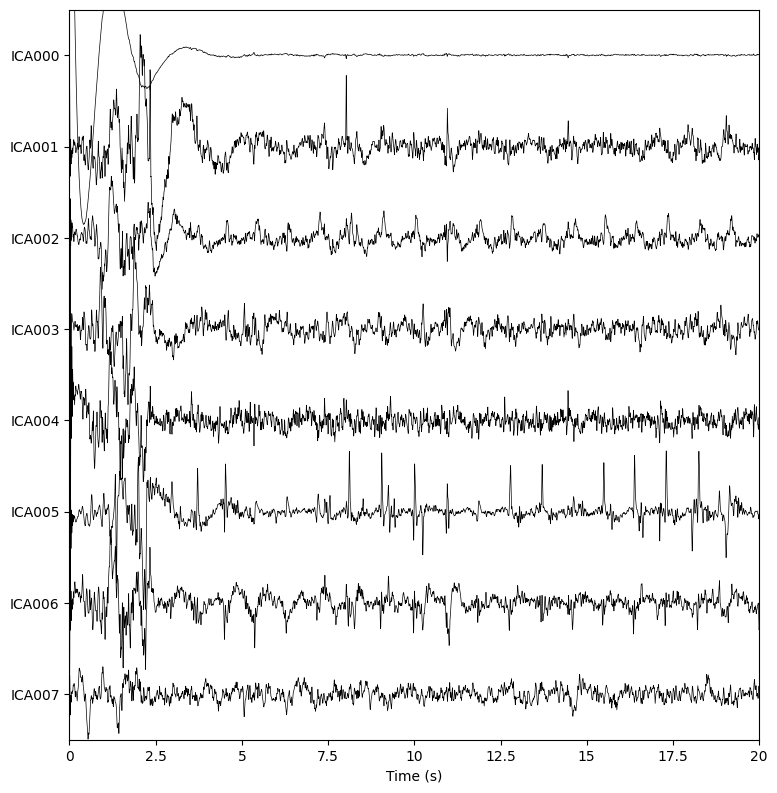

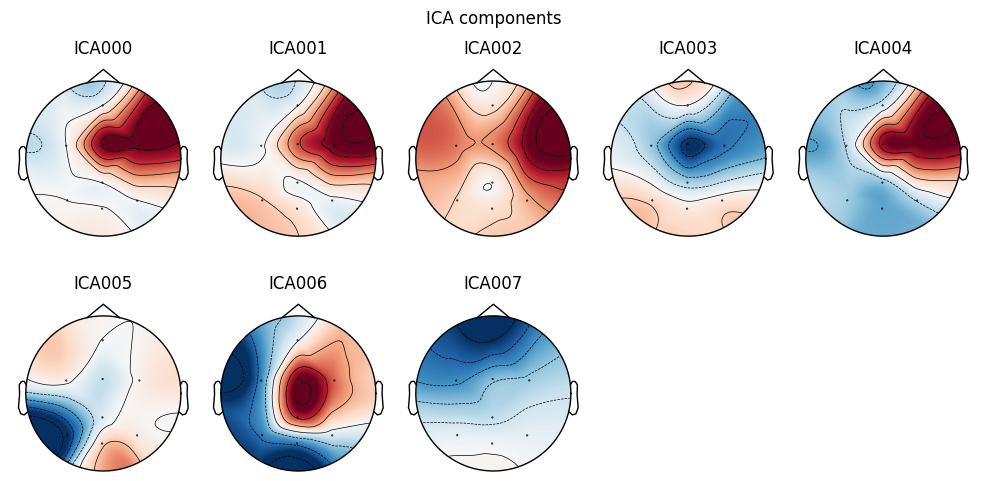

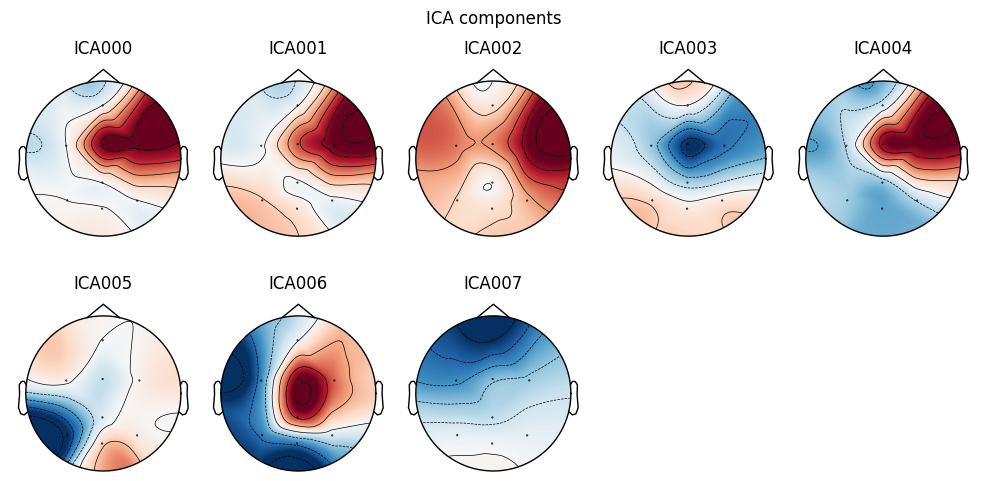

In [380]:
# Plot the raw data channels and also the ICA signal components
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_components(picks=range(num_components), ch_type='eeg')


In [381]:
# # ICA plot overlay to see difference when excluding
# ica.plot_overlay(raw, exclude=[0,1], picks="eeg")

In [382]:
#ica.plot_properties(raw, picks=[0, 1])

In [419]:
bad_channels_l = []
i = 0

# Cycle through exclude indices from 0 to 7
for exclude_index in range(8):
    dif_l1 = []
    # Change the indices which needs to be removed based on the plots and bad channels
    ica.exclude = [exclude_index]  # indices chosen based on various plots above

    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)

    # Transpose to recreate the original shape
    raw_array = raw[:][0].T
    reconst_raw_array = reconst_raw[:][0].T

    for channel in range(8):
        for j in range (6):
            # assign raw and reconstructed signal to variables
            signal1 = raw_array[12000*j : 12000*(j+1),channel]
            signal2 = reconst_raw_array[12000*j : 12000*(j+1),channel]

            # calculate the minimum and maximum of both signals to determine peaks
            max1 = np.max(signal1)
            max2 = np.max(signal2)
            min1 = np.min(signal1)
            min2 = np.min(signal2)

            vars1 = np.var(signal1)
            vars2 = np.var(signal2)

            print(vars1, vars2)

            # # # Calculate the difference betweeen man and min of both signals
            dif1 = max1 - min1
            dif2 = max2 - min2

            # # Append to list
            # dif_l1.append(dif2-dif1)

            # if vars2 * 2 < vars1:
            #     bad_channels_l.append(i)

            if (dif2 - dif1) > 50:
                bad_channels_l.append(i)

        # bad_channels = [i for i, value in enumerate(dif_l1) if value > 30]
        # if len(bad_channels) > 0:
        #     bad_channels_l.append(i)
    
    # # plot the original and ICA filtered signal
    # x1 = np.linspace(0, end/fs, end, endpoint=True)

    # fig, axs = plt.subplots(8, figsize=(10 , 10))
    # fig.suptitle(f'EEG signals channel {exclude_index} excluded')
    # for i in range(8):
    #     # axs[i].plot(x1[1000:],raw_array[1000:,i])
    #     # axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
    #     axs[i].plot(x1[:],raw_array[:,i])
    #     axs[i].plot(x1[:],reconst_raw_array[:,i])
    #     axs[i].set_xlabel('Time (seconds)')
    #     axs[i].set_ylabel(f'Channel {i+1}')

    # plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    # plt.show()

    i += 1
    
print(bad_channels_l)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
81.40384398470565 71.36995551679152
61.357454114972924 61.16935599727022
58.363281725608296 58.17413741268794
63.688201115693374 63.45372823635698
58.045916913929354 57.83301056790149
70.28658298004628 70.03339049182276
241.18638725717804 237.29408068188172
181.26778245668714 181.33587803053777
156.63822056266366 156.65498060150557
144.47818213772842 144.48126801513433
137.47909331803012 137.44316527723984
150.25971701254736 150.3555637519962
1318677.9952742034 1895.6434159074142
131.73006479464502 541.0582387241697
131.30189252127929 533.4536673758811
116.08074691754346 492.95584672827624
105.17619051602824 468.8379665633685
107.36774751004889 586.4047131526044
1355171.592437997 3090.7595163845676
164.86419420719307 803.6992576584413
152.83594772121512 741.2167761729866
148.3676321877121 689.6870796140979
132.7556226452357 648.91605076829

In [420]:
# Change the indices which needs to be removed based on the plots and bad channels
ica.exclude = bad_channels_l  # indices chosen based on various plots above
#[0,3,4,5]
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 6 ICA components
    Projecting back using 8 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.50 Hz
Lowpass,38.00 Hz


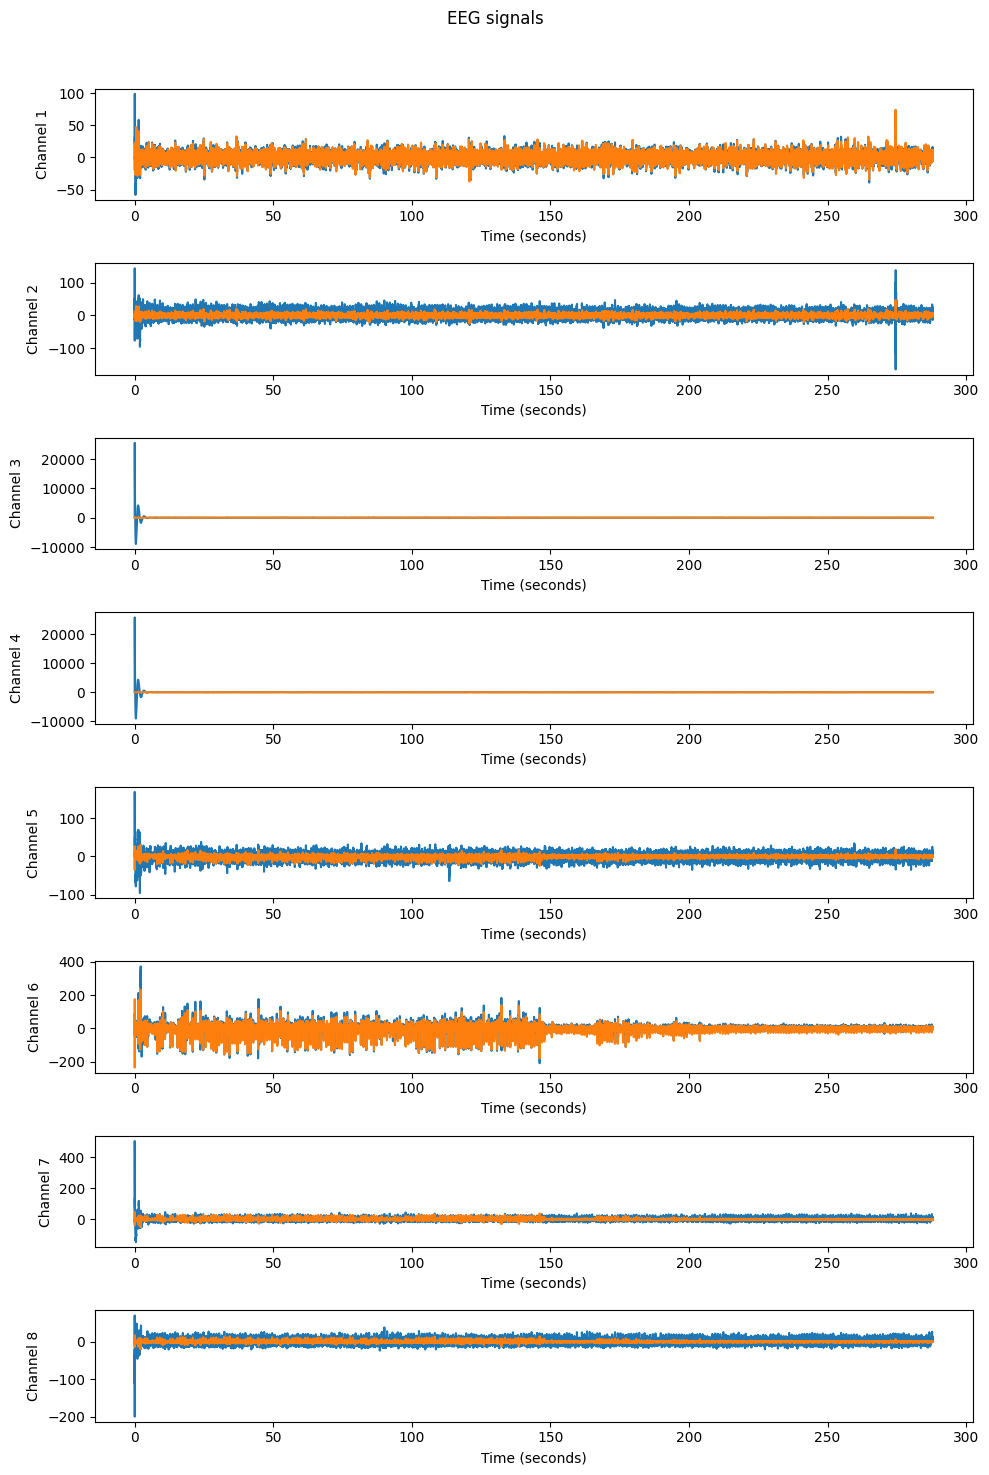

In [421]:
# Transpose to recreate the original shape
raw_array = raw[:][0].T
reconst_raw_array = reconst_raw[:][0].T

# plot the original and ICA filtered signal
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    # axs[i].plot(x1[1000:],raw_array[1000:,i])
    # axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
    axs[i].plot(x1[:],raw_array[:,i])
    axs[i].plot(x1[:],reconst_raw_array[:,i])
    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel(f'Channel {i+1}')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

In [386]:
# Convert ICA signal to csv file and add columns which were removed before ICA
ICA_data = pd.DataFrame(reconst_raw_array)

# Add columns that were removed
df = pd.read_csv(path+filename + ".csv", sep=",")
columns_add = df[['Counter', 'Validation', 'Label']] # select the last three columns to be added

# Rename the columns of df2 to correspond to the first 8 columns of df1
ICA_data.columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

# Adding the last three columns to ICA_data
ICA_data = pd.concat([ICA_data, columns_add], axis=1)


#ICA_data.to_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/" +filename + "_ICA.csv", index = False)

In [387]:
ICA_data

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,Counter,Validation,Label
0,0.003387,0.023036,-0.937188,-0.925161,-0.005210,0.010172,-0.004564,0.021433,10219.0,1.0,0
1,59.156736,163.755584,-393.795593,-322.746301,93.613018,52.998313,325.163643,125.553040,10220.0,1.0,0
2,72.626325,215.128050,-497.785963,-398.087308,120.660279,69.549553,427.572897,162.053935,10221.0,1.0,0
3,31.564877,125.410491,-246.366670,-174.384368,65.619804,41.231754,249.590772,87.892867,10222.0,1.0,0
4,-30.104209,-32.917362,162.065351,172.326237,-26.277012,-7.056826,-66.073610,-37.649747,10223.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
72000,-5.391926,-19.774616,-34.386964,-39.031665,-0.592507,-4.993702,-6.422514,2.263041,82219.0,1.0,0
72001,-4.663548,-17.263901,-20.710831,-23.207178,-0.508080,-4.192926,-6.968594,0.654269,82220.0,1.0,0
72002,-3.228478,-12.428893,-9.770872,-10.649785,-0.156899,-2.982644,-5.700485,-0.223515,82221.0,1.0,0
72003,-1.589207,-6.394917,-3.610654,-3.731993,0.048618,-1.526032,-3.145327,-0.331482,82222.0,1.0,0
